In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import bilby
import h5py
from scipy.integrate import quad
from tqdm import tqdm

07:16 bilby INFO    : Running bilby version: 0.5.2:


In [2]:
def gw_luminosity_distance_csi(z,cosmology,csi0,n):
    dl_cosmo = cosmology.luminosity_distance(z).value
    return dl_cosmo*(csi0+(1-csi0)/((1+z)**n))

In [3]:
def gw_luminosity_distance_extra(z,cosmology,D):
    dl_cosmo = cosmology.luminosity_distance(z).value
    return dl_cosmo**((D-2)/2)

In [4]:
def gw_luminosity_distance_cm(z,cosmology,cm):
    """ This function computes the Gw luminosity distance
    
    Parameters
    ----------
    z: array
        Cosmological redshift
    cosmology: astropy.cosmo
        cosmology class from astropy
    cm: float
        Friction parameter
    
    Returns
    -------
    Luminosity distance in Mpc
    
    """
    
    dl_cosmo = cosmology.luminosity_distance(z).value
    Om0 = cosmology.Om0
    OL0 = 1-Om0
    
    return dl_cosmo*np.exp((0.5*cm/OL0)*np.log((1+z)/(OL0+Om0*(1+z)**3)**(1/3)))

In [5]:
data_p = np.genfromtxt('NRSur/planck_mass_prior_planck_GW170817_GW190521/emcee_label/chain.dat',names=True)


In [6]:
z_170817=0.010033618884026258
z_190521=0.438

z_array=[z_170817,z_190521]

In [7]:
G_eff_cm_ul={}
M_eff_cm_ul={}

for waveform in ['NRSur','IMRPhenom','SEONBR']:
    
    for prior in ['planck','all']:

        data= np.genfromtxt(waveform+
                               '/planck_mass_prior_'+prior+'_GW170817_GW190521/emcee_label/chain.dat',names=True)
        
        G_eff_cm_ul[waveform+prior]=[]
        M_eff_cm_ul[waveform+prior]=[]

        for z in z_array:

            d_gw_over_em= []
            
            for i in tqdm(range(len(data_p['H0']))):

                cosmo= FlatLambdaCDM(H0=data['H0'][i],Om0=data['Om0'][i])
                
                d_gw_over_em.append(gw_luminosity_distance_cm(z,cosmo,data['cm'][i])
                                      /gw_luminosity_distance_cm(z,cosmo,0))

            d_gw_over_em=np.array(d_gw_over_em)
            
            M_eff_cm_ul[waveform+prior].append(np.percentile(d_gw_over_em,95))
            G_eff_cm_ul[waveform+prior].append(np.percentile(d_gw_over_em**2,95))


    
    


100%|██████████| 60000/60000 [00:46<00:00, 1279.84it/s]


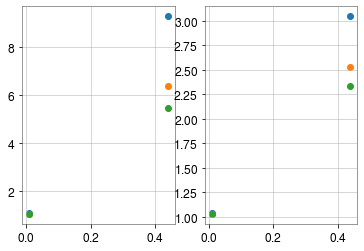

In [8]:
fig, ax = plt.subplots(1,2)

for waveform in ['NRSur','IMRPhenom','SEONBR']:
    
    ax[0].scatter(z_array,G_eff_cm_ul[waveform+'planck'],label=waveform+'planck')
    ax[1].scatter(z_array,M_eff_cm_ul[waveform+'planck'],label=waveform+'planck')

In [9]:
np.percentile(d_gw_over_em,-95*.5+50)

1.0811524704679725

In [25]:
G_eff_csi_err={}
M_eff_csi_err={}

G_eff_csi_med={}
M_eff_csi_med={}

for waveform in ['NRSur','IMRPhenom','SEONBR']:
    
    for prior in ['planck','all']:

        data= np.genfromtxt(waveform+
                               '/RTmodel_mass_prior_'+prior+'_GW170817_GW190521/emcee_label/chain.dat',names=True)
        
        G_eff_csi_err[waveform+prior]=np.zeros((2,2))
        M_eff_csi_err[waveform+prior]=np.zeros((2,2))
        
        G_eff_csi_med[waveform+prior]=[]
        M_eff_csi_med[waveform+prior]=[]
        
        j=0
        for z in z_array:

            d_gw_over_em= []
            
            for i in tqdm(range(len(data_p['H0']))):

                cosmo= FlatLambdaCDM(H0=data['H0'][i],Om0=data['Om0'][i])
                
                d_gw_over_em.append(gw_luminosity_distance_csi(z,cosmo,data['csi0'][i],data['n'][i])
                                      /gw_luminosity_distance_csi(z,cosmo,1,0))

            d_gw_over_em=np.array(d_gw_over_em)
            #d_gw_over_em=d_gw_over_em[d_gw_over_em<=25]
            
            M_eff_csi_med[waveform+prior].append(np.median(d_gw_over_em))
            G_eff_csi_med[waveform+prior].append(np.median(d_gw_over_em**2))
            
            M_eff_csi_err[waveform+prior][1,j]=np.percentile(d_gw_over_em,95*0.5+50)-np.median(d_gw_over_em)
            G_eff_csi_err[waveform+prior][1,j]=np.percentile(d_gw_over_em**2,95*0.5+50)-np.median(d_gw_over_em**2)
            
            M_eff_csi_err[waveform+prior][0,j]=np.median(d_gw_over_em)-np.percentile(d_gw_over_em,-95*0.5+50)
            G_eff_csi_err[waveform+prior][0,j]=np.median(d_gw_over_em**2)-np.percentile(d_gw_over_em**2,-95*0.5+50)
            
            j+=1


    
    


100%|██████████| 60000/60000 [00:39<00:00, 1529.17it/s]


(array([ 30.,  60., 118., ...,   0.,   0.,   4.]),
 array([ 0.37468222,  0.4540014 ,  0.53332058, ..., 73.42764802,
        73.5069672 , 73.58628638]),
 <BarContainer object of 923 artists>)

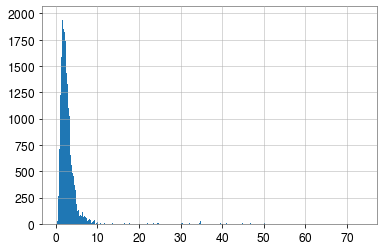

In [26]:
plt.hist(d_gw_over_em,bins='auto')

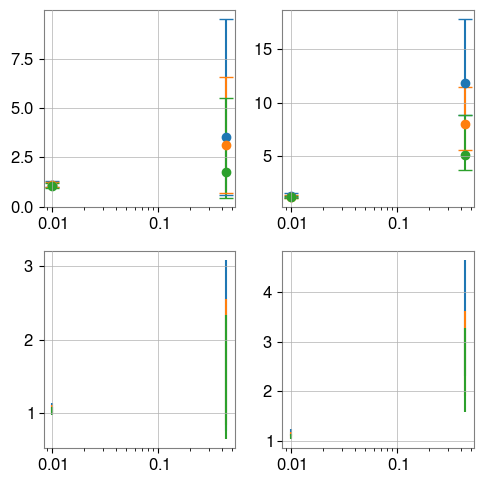

In [27]:
fig, ax = plt.subplots(2,2,dpi=100,figsize=(5,5))

for waveform in ['NRSur','IMRPhenom','SEONBR']:
    
    ax[0,0].errorbar(z_array,G_eff_csi_med[waveform+'planck'],
                   yerr=G_eff_csi_err[waveform+'planck'],label=waveform+'planck',linestyle="None",
                  fmt='o',capsize=5)

    ax[1,0].errorbar(z_array,M_eff_csi_med[waveform+'planck'],
                   yerr=M_eff_csi_err[waveform+'planck'],label=waveform+'planck',linestyle="None")
    
    ax[0,1].errorbar(z_array,G_eff_csi_med[waveform+'all'],
                   yerr=G_eff_csi_err[waveform+'planck'],label=waveform+'planck',linestyle="None",
                  fmt='o',capsize=5)

    ax[1,1].errorbar(z_array,M_eff_csi_med[waveform+'all'],
                   yerr=M_eff_csi_err[waveform+'planck'],label=waveform+'planck',linestyle="None")
    
    
    
    
    ax[0,0].set_xscale('log')
    ax[0,1].set_xscale('log')
    ax[1,0].set_xscale('log')
    ax[1,1].set_xscale('log')
    plt.tight_layout()

In [34]:
M_eff_csi_med


{'NRSurplanck': [1.045519014657984, 1.8789087402142957],
 'NRSurall': [1.1542822488051856, 3.4387356868910346],
 'IMRPhenomplanck': [1.0408568536739777, 1.7713885986762645],
 'IMRPhenomall': [1.116827725410318, 2.8324672675229143],
 'SEONBRplanck': [1.0178478529847144, 1.3326267342022309],
 'SEONBRall': [1.0759800013032415, 2.2637469366244325]}

In [35]:
M_eff_csi_err

{'NRSurplanck': array([[0.05849244, 1.12447748],
        [0.09339335, 1.20623645]]),
 'NRSurall': array([[0.15075481, 2.36494829],
        [0.6301091 , 7.06229179]]),
 'IMRPhenomplanck': array([[0.04920551, 0.93412141],
        [0.06590055, 0.78771309]]),
 'IMRPhenomall': array([[0.10671072, 1.63421773],
        [0.4598878 , 5.80374641]]),
 'SEONBRplanck': array([[0.03935189, 0.68737852],
        [0.07148632, 1.01044691]]),
 'SEONBRall': array([[0.08410339, 1.42837909],
        [0.41722017, 5.05598475]])}

In [36]:
G_eff_csi_med


    

{'NRSurplanck': [1.0931100100114017, 3.530298054367721],
 'NRSurall': [1.3323675099067565, 11.824903124297956],
 'IMRPhenomplanck': [1.0833829898400924, 3.13781756752026],
 'IMRPhenomall': [1.247304168491878, 8.022870821588725],
 'SEONBRplanck': [1.0360142518255928, 1.775894014596675],
 'SEONBRall': [1.1577329632045235, 5.1245501930765025]}

In [37]:
G_eff_csi_err

{'NRSurplanck': array([[0.11888856, 2.96113152],
        [0.20401135, 5.98782279]]),
 'NRSurall': array([[ 0.32530018, 10.67188376],
        [ 1.85168496, 98.44667492]]),
 'IMRPhenomplanck': array([[0.1000106 , 2.43680122],
        [0.14152896, 3.41118391]]),
 'IMRPhenomall': array([[ 0.22696781,  6.58706888],
        [ 1.23872767, 66.56131581]]),
 'SEONBRplanck': array([[0.0785599 , 1.35954876],
        [0.1506347 , 3.7141001 ]]),
 'SEONBRall': array([[ 0.17391374,  4.42671075],
        [ 1.0719138 , 48.45392175]])}

In [38]:
M_eff_cm_ul

{'NRSurplanck': [1.0381526999330348, 3.04749359430707],
 'NRSurall': [1.0679940612083492, 5.070843198974521],
 'IMRPhenomplanck': [1.031655140144203, 2.5259745078520286],
 'IMRPhenomall': [1.0593978239683486, 4.132935780186081],
 'SEONBRplanck': [1.028950546824636, 2.337045754708212],
 'SEONBRall': [1.0549738443169807, 3.7689926157218734]}

In [39]:
G_eff_cm_ul

{'NRSurplanck': [1.0777610283783692, 9.287217207458843],
 'NRSurall': [1.140611314776319, 25.71345074865704],
 'IMRPhenomplanck': [1.064312328186017, 6.380547214318298],
 'IMRPhenomall': [1.122323749428872, 17.08115816314233],
 'SEONBRplanck': [1.0587392278107175, 5.461782859599677],
 'SEONBRall': [1.1129698121939096, 14.205305339805655]}